# Sectoral breakdown of feedstock consumption (or total bioenergy demand) at the national level

Input:
- Feedstock consumption for sectoral bioenergy demand at the national level in BioEnerHigh, BioEnerLow, and LimFor

Aims:
- For policy makers to understand the feedstock supply to meet total bioenergy demand
- For NGOs to push narratives on decarbonising energy system and on implementing measures that promote energy efficiency. To meet energy demand through biomass supply, it would need:
  - Increase in forestry biomass, incl. harvestable wood
  - Increase in energy crops
  - Finding alternative energy source such as natural gas
- For forest industries and civil society to understand the growth of different feedstock types and to find new business models

Output:
- Pie chart over a basemap of EU countries showing the contribution of economic sectors in consuming biomass feedstocks
- Covering 2030
- Three scenarios

In [2]:
# Data modification
import pandas as pd
import numpy as np
import pyam

# Geospatial
import geopandas as gpd

# System
from pathlib import Path
from pyam import IamDataFrame
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
# Plotting
import matplotlib.pyplot as plt

# Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Output directory

In [3]:
out_dir = Path.cwd() / ".." / "output_data"

In [4]:
out_fig_dir = Path.cwd() / ".." / "output_figures"

In [79]:
input_dir = Path.cwd() / ".." / "input_data"

# Get a list of EU countries
sheets_dict = pd.read_excel(f"{input_dir}/FN_WP5_Feedstocks_High_Bioenergy_v2_shared.xlsx", sheet_name=None)

excluded_sheets = {"Cover", "info", "EU27", "EL", "LX", "LA"}
eu_countries = [k for k in sheets_dict.keys() if k not in excluded_sheets]

In [78]:
# Length = 24
len(sheet_name)

24

# Scenario data

In [10]:
# Scenario data is a processed dataset, it is stored in output_data directory
master_df = pyam.IamDataFrame(pd.read_csv(f"{input_dir}/master_scenarios_aggregated.csv"))

In [13]:
# The shape of the master_dataset (41160, 8)
master_df.timeseries().shape

(41160, 8)

In [14]:
# Available scenarios
master_df.scenario

['BioEnerHigh', 'BioEnerLow', 'LimFor']

In [15]:
# To plot the sectoral breakdown of bioenergy demand
master_df.filter(variable="*Demand").variable

['Electricity And District Heat Demand',
 'Household Demand',
 'Industry Demand',
 'Tertiary And Other Demand',
 'Transport Demand']

In [45]:
# Select one scenario of sectoral bioenergy demand in 2030 for Germany
de_bio_demand_2030 = master_df.filter(
    variable="*Demand", 
    region="DE", 
    scenario="BioEnerHigh", 
    unit="EJ", 
    year=2030
)

In [46]:
de_bio_demand_2030.timeseries()

2030
model     scenario    region variable                             unit          
D5.1 Data BioEnerHigh DE     Electricity And District Heat Demand EJ    0.841170
                             Household Demand                     EJ    0.261445
                             Industry Demand                      EJ    0.184469
                             Tertiary And Other Demand            EJ    0.154894
                             Transport Demand                     EJ    0.289816

[Text(0.5, 1.0, 'Sectoral breakdown of feedstock consumption in 2030\nBioEnerHigh\nGermany')]

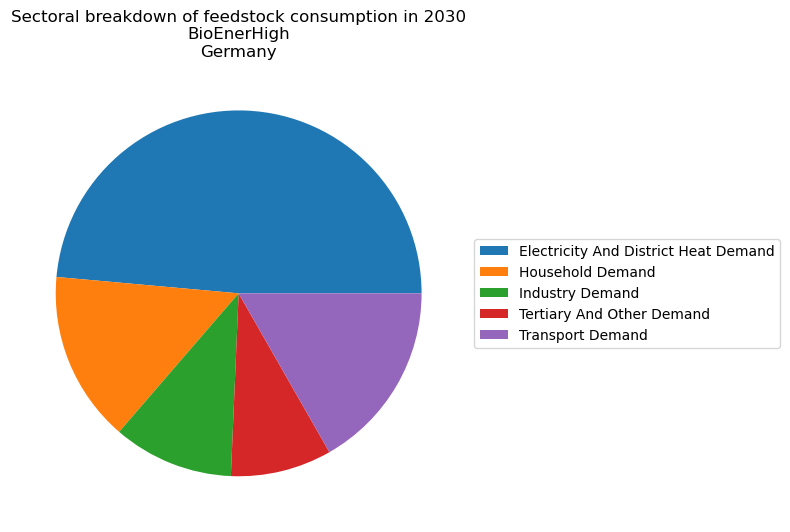

In [47]:
# Prepare a pie chart using a pyam function
fig, ax_1 = plt.subplots(figsize=(8, 12))
plt.subplots_adjust()

de_bio_demand_2030.plot.pie(labels=None, legend=True, ax=ax_1)

# This should be a suptitle when combining pie chart and basemap
plt.tight_layout()
ax_1.set(title="Sectoral breakdown of feedstock consumption in 2030\nBioEnerHigh\nGermany")

# Import country borders

In [16]:
country_borders = gpd.read_file(f"{input_dir}/WORLD_BORDERS").set_index("ISO2")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1536\2726975445.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


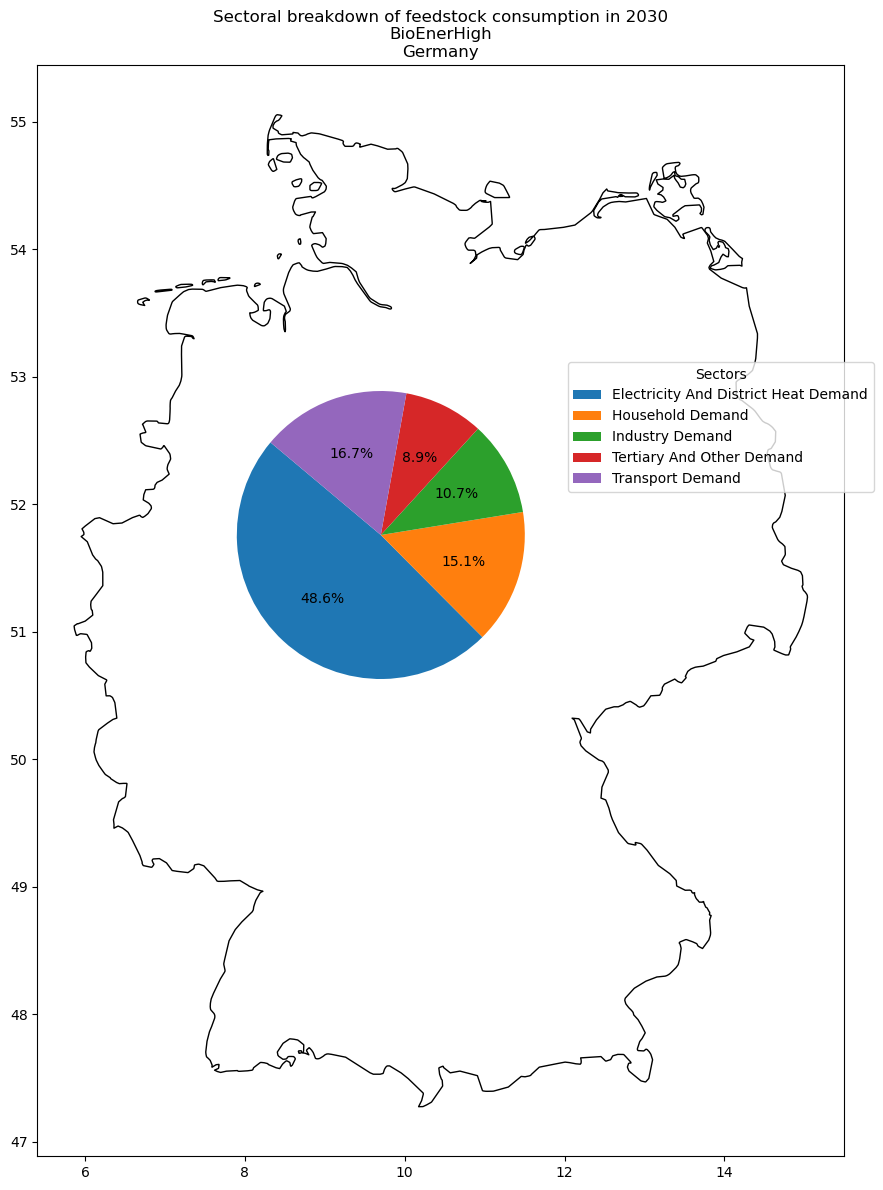

In [54]:
# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot Germany borders
de_borders.plot(ax=ax, color='white', edgecolor='black')

# Prepare data for pie chart
labels = de_bio_demand_2030.variable
sizes = de_bio_demand_2030.timeseries().values.flatten()

# Add the pie chart
pie_ax = fig.add_axes([0.3, 0.4, 0.3, 0.3])  # [left, bottom, width, height] in figure coordinates
wedges, texts, autotexts = pie_ax.pie(sizes, autopct='%1.1f%%', startangle=140)

# Style the pie chart
for text in texts + autotexts:
    text.set_fontsize(10)

# Add the legend to the top-right
pie_ax.legend(wedges, labels, title="Sectors", loc="best", bbox_to_anchor=(1, 1))

# Set titles and layout
ax.set_title("Sectoral breakdown of feedstock consumption in 2030\nBioEnerHigh\nGermany")
plt.tight_layout()

plt.show()

# Pie Charts

Hi Sajid, I did the first try to set the pipeline into a function. See the parts where I put comments. Those are the examples on how you filter variable, scenario, and year from a `pyam.IamDataFrame`

In [80]:
def map_view_pie(
    list_eu_countries=eu_countries,
    gpd_borders=country_borders,
    sel_var="*Demand",
    sel_scenario="BioEnerHigh",
    sel_year=2030,
    output_dir=out_fig_dir,
):
    # Filter to EU countries
    eu_borders = gpd_borders.loc[list_eu_countries]

    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))

    # Plot EU borders
    eu_borders.plot(ax=ax, color='white', edgecolor='black')

    # Function to create a pie chart as an image
    def pie_image(sizes, colors=None):
        fig, pie_ax = plt.subplots()
        wedges, _ = pie_ax.pie(sizes, labels=None, startangle=140, colors=colors)
        pie_ax.axis('equal')
        fig.patch.set_alpha(0)  # Set the figure background to be transparent
        pie_ax.patch.set_alpha(0)   # Set the axes background to be transparent
        
        fig.canvas.draw()
        
        # Create an image from the figure, ensuring transparency
        image = np.frombuffer(fig.canvas.tostring_argb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        plt.close(fig)
        
        # Reorder ARGB to RGBA
        image = image[:, :, [1, 2, 3, 0]]
        return image, wedges

    # Calculate total demand for scaling purposes
    total_demands = []
    for country_code in list_eu_countries:

        # FR: I changed this part. This is the example for filtering pyam.IamDataFrame components
        # FR: Check the input for sel_var, sel_scenario parameters in the beginning of the function
        country_demand = master_df.filter(
            variable=sel_var, 
            region=country_code, 
            scenario=sel_scenario, 
            unit="EJ", 
            year=sel_year
        )
        if not country_demand.empty:
            total_demands.append(country_demand.timeseries().sum().sum())

    max_demand = max(total_demands) if total_demands else 1

    # Initialize lists for wedges and labels for the pie chart legend
    all_wedges = []
    all_labels = []

    # Loop through each EU country and plot the respective pie chart
    for country_code in list_eu_countries:
        # Filter data for the specific country and year
        country_demand = master_df.filter(
            variable=sel_var, 
            region=country_code, 
            scenario=sel_scenario, 
            unit="EJ", 
            year=sel_year
        )

        # Skip countries with no data
        if country_demand.empty:
            continue

        # Prepare data for pie chart
        sizes = country_demand.timeseries().values.flatten()
        variables = country_demand.variable

        # Calculate the centroid of the country
        centroid = eu_borders.loc[country_code].geometry.centroid

        # Create a pie chart image
        # FR: We may need to think to customise the color later - depending on discussion with webdev
        pie_img, wedges = pie_image(sizes, colors=plt.cm.tab20(np.linspace(0, 1, len(sizes))))

        # Store wedges and labels for legend
        if not all_wedges:
            all_wedges = wedges
            all_labels = [label.split('|')[-1] for label in variables]
        
        # Scale factor for pie size based on total demand
        total_demand = sizes.sum()
        scale_factor = 0.15 * (total_demand / max_demand)  # Adjust this scale factor as needed

        # Create an AnnotationBbox with the pie chart image
        imagebox = OffsetImage(pie_img, zoom=scale_factor)
        ab = AnnotationBbox(imagebox, (centroid.x, centroid.y), frameon=False)

        # Add the AnnotationBbox to the plot
        ax.add_artist(ab)

        # Add the country's ISO code above the pie chart image
        ax.text(centroid.x, centroid.y + 0.50, country_code, ha='center', va='bottom', fontsize=12, color='red')


    # Create a custom legend for the size scale using nested black circles
    legend_labels = [0.25 * max_demand, 0.5 * max_demand, 0.75 * max_demand, max_demand]
    legend_positions = [(0.15, 0.55), (0.15, 0.65), (0.15, 0.75), (0.15, 0.85)]

    for label, pos in zip(legend_labels, legend_positions):
        scale_factor = 0.05 * (label / max_demand)
        circle = plt.Circle((pos[0], pos[1]), scale_factor, color='black', transform=ax.transAxes, alpha=0.5)
        ax.add_patch(circle)
        ax.text(pos[0] + 0.05, pos[1], f'{label:.1f} EJ', transform=ax.transAxes, fontsize=10, verticalalignment='center')

    # Note: Ensure the bbox_to_anchor values are adjusted as needed
    pie_legend = ax.legend(all_wedges, all_labels, title="Sectors", loc="best", bbox_to_anchor=(0.2, 1))

    # Set the title and layout
    ax.set_title(f"Sectoral breakdown of feedstock consumption in {sel_year}\n{sel_scenario}\nEU Countries")
    plt.tight_layout()

    # Save figure
    # FR to Sajid: Adapt this code if you're planning to export as an HTML
    f_dir = f"{output_dir}/{sel_scenario}_{sel_year}_map_sectoral_demand.png"
    plt.savefig(f_dir, dpi=300)
    print("Figure is saved to...", f_dir)

    return plt.show()

Figure is saved to... /Users/firzariany/Documents/repo/forest_data_analysis/notebook/../output_figures/BioEnerHigh_2030_map_sectoral_demand.png


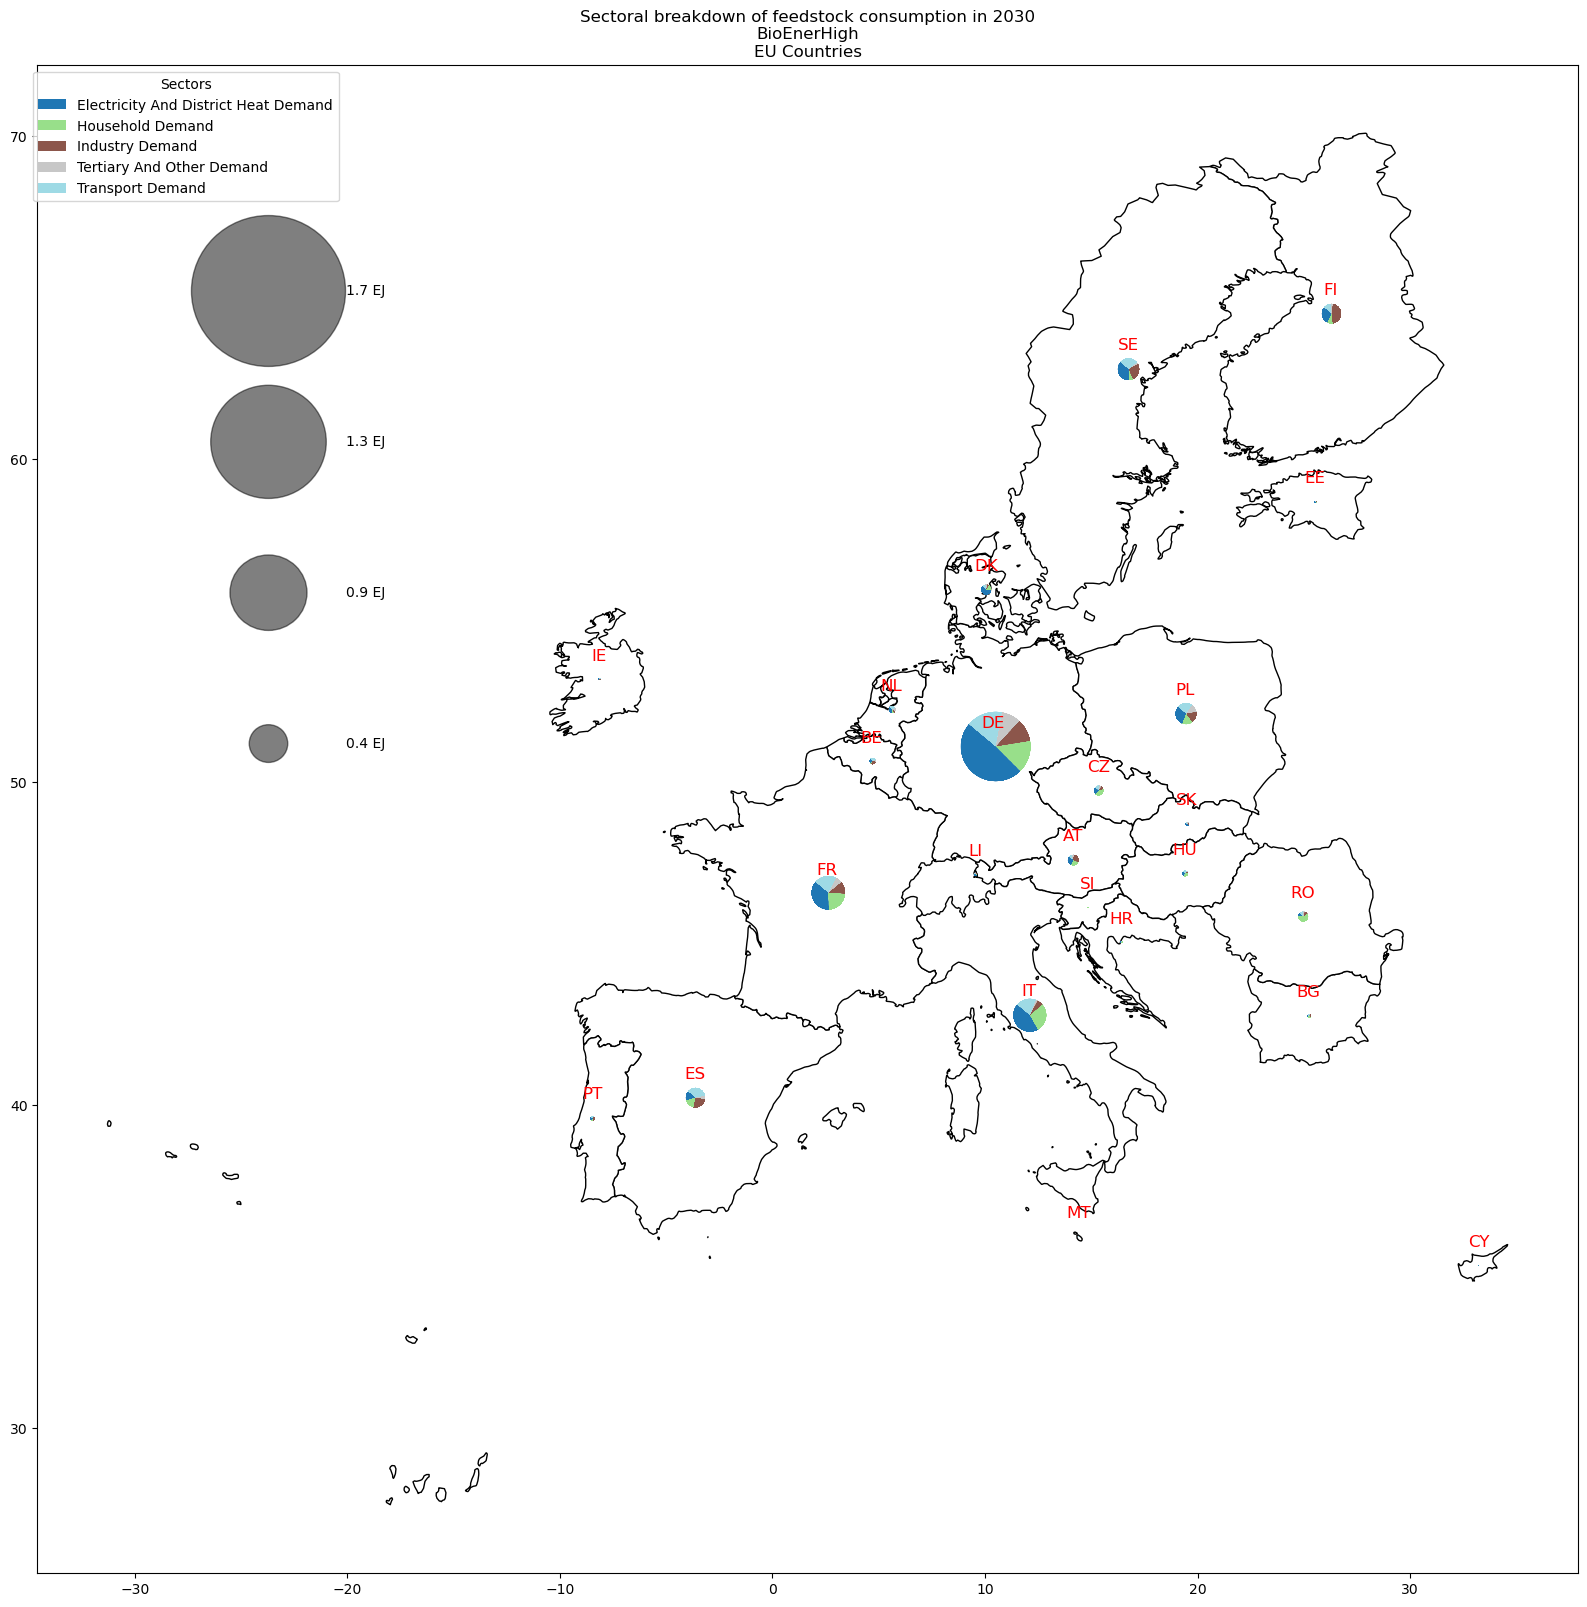

In [81]:
map_view_pie()

---
# Notes

[WARNING] 06:51:13 - pyam.core: Filtered IamDataFrame is empty!
[WARNING] 06:51:13 - pyam.core: Filtered IamDataFrame is empty!
[WARNING] 06:51:13 - pyam.core: Filtered IamDataFrame is empty!
[WARNING] 06:51:13 - pyam.core: Filtered IamDataFrame is empty!


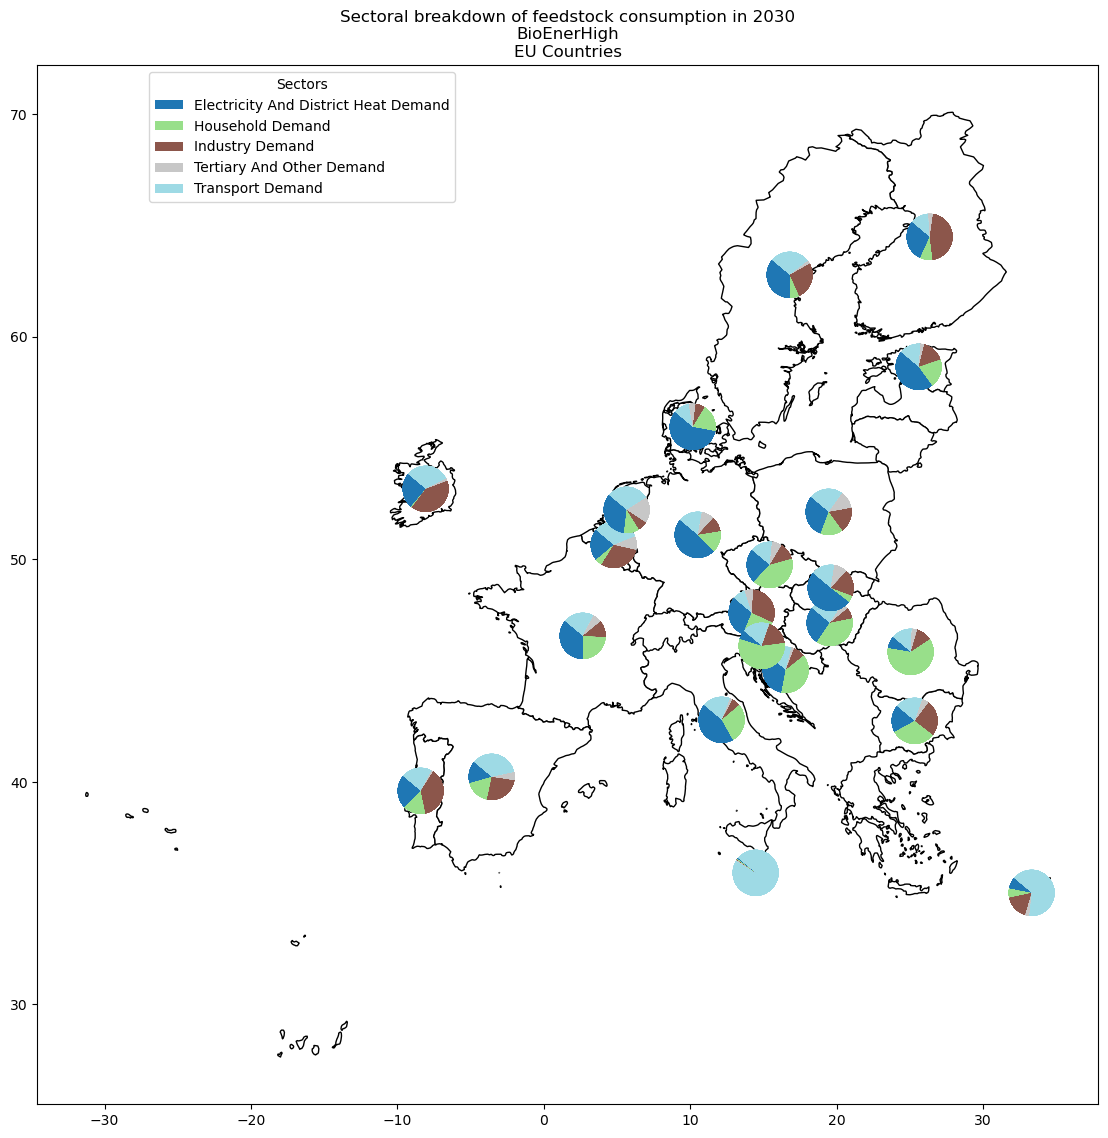

In [99]:
# List of EU countries
eu_countries = [
    "AT", "BE", "BG", "HR", "CY", "CZ", "DK", "EE", "FI", "FR", "DE",
    "GR", "HU", "IE", "IT", "LV", "LT", "LU", "MT", "NL", "PL", "PT",
    "RO", "SK", "SI", "ES", "SE"
]

# Filter to EU countries
eu_borders = country_borders.loc[eu_countries]

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(16, 16))

# Plot EU borders
eu_borders.plot(ax=ax, color='white', edgecolor='black')

# Function to create a pie chart as an image
def pie_image(sizes, colors=None):
    fig, ax = plt.subplots()
    wedges, _ = ax.pie(sizes, labels=None, startangle=140, colors=colors)
    ax.axis('equal')
    fig.patch.set_alpha(0)  # Set the figure background to be transparent
    ax.patch.set_alpha(0)   # Set the axes background to be transparent
    
    fig.canvas.draw()
    
    # Create an image from the figure, ensuring transparency
    image = np.frombuffer(fig.canvas.tostring_argb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    plt.close(fig)
    
    # Reorder ARGB to RGBA
    image = image[:, :, [1, 2, 3, 0]]
    return image

# Prepare to collect legend handles and labels
legend_handles = []
legend_labels = []

# Loop through each EU country and plot the respective pie chart
for country_code in eu_countries:
    # Filter data for the specific country and year
    country_demand = master_df.filter(
        variable="*Demand", 
        region=country_code, 
        scenario="BioEnerHigh", 
        unit="EJ", 
        year=2030
    )

    # Skip countries with no data
    if country_demand.empty:
        continue

    # Prepare data for pie chart 
    sizes = country_demand.timeseries().values.flatten()
    variables = country_demand.timeseries().index.get_level_values('variable').unique() # Revise with pyam functionality
    
    # Generate colors for the pie chart
    colors = plt.cm.tab20(np.linspace(0, 1, len(sizes)))

    # Add color and label for legend
    if not legend_handles:
        # Generate a dummy pie chart to get the handles for the legend
        fig, dummy_ax = plt.subplots()
        wedges, _ = dummy_ax.pie(sizes, colors=colors, labels=variables)
        plt.close(fig)
        legend_handles = wedges
        legend_labels = variables

    # Calculate the centroid of the country
    centroid = eu_borders.loc[country_code].geometry.centroid

    # Create a pie chart image
    pie_img = pie_image(sizes, colors=colors)

    # Use a fixed zoom value for the pie size
    zoom = 0.1  # Adjust this zoom factor as needed

    # Create an AnnotationBbox with the pie chart image
    imagebox = OffsetImage(pie_img, zoom=zoom)
    ab = AnnotationBbox(imagebox, (centroid.x, centroid.y), frameon=False)
    
    # Add the AnnotationBbox to the plot
    ax.add_artist(ab)

# Create a custom legend for the pie chart colors
ax.legend(legend_handles, legend_labels, title="Sectors", loc="upper right", bbox_to_anchor=(0.4, 1))

# Set the title and layout
ax.set_title("Sectoral breakdown of feedstock consumption in 2030\nBioEnerHigh\nEU Countries")
plt.tight_layout()

# Adjust layout to fit everything
plt.subplots_adjust(right=0.8)
plt.show()

Need to check:
- Can I convert unit to Watts?

[WARNING] 06:55:26 - pyam.core: Filtered IamDataFrame is empty!
[WARNING] 06:55:26 - pyam.core: Filtered IamDataFrame is empty!
[WARNING] 06:55:26 - pyam.core: Filtered IamDataFrame is empty!
[WARNING] 06:55:26 - pyam.core: Filtered IamDataFrame is empty!
[WARNING] 06:55:27 - pyam.core: Filtered IamDataFrame is empty!
[WARNING] 06:55:27 - pyam.core: Filtered IamDataFrame is empty!
[WARNING] 06:55:27 - pyam.core: Filtered IamDataFrame is empty!
[WARNING] 06:55:27 - pyam.core: Filtered IamDataFrame is empty!


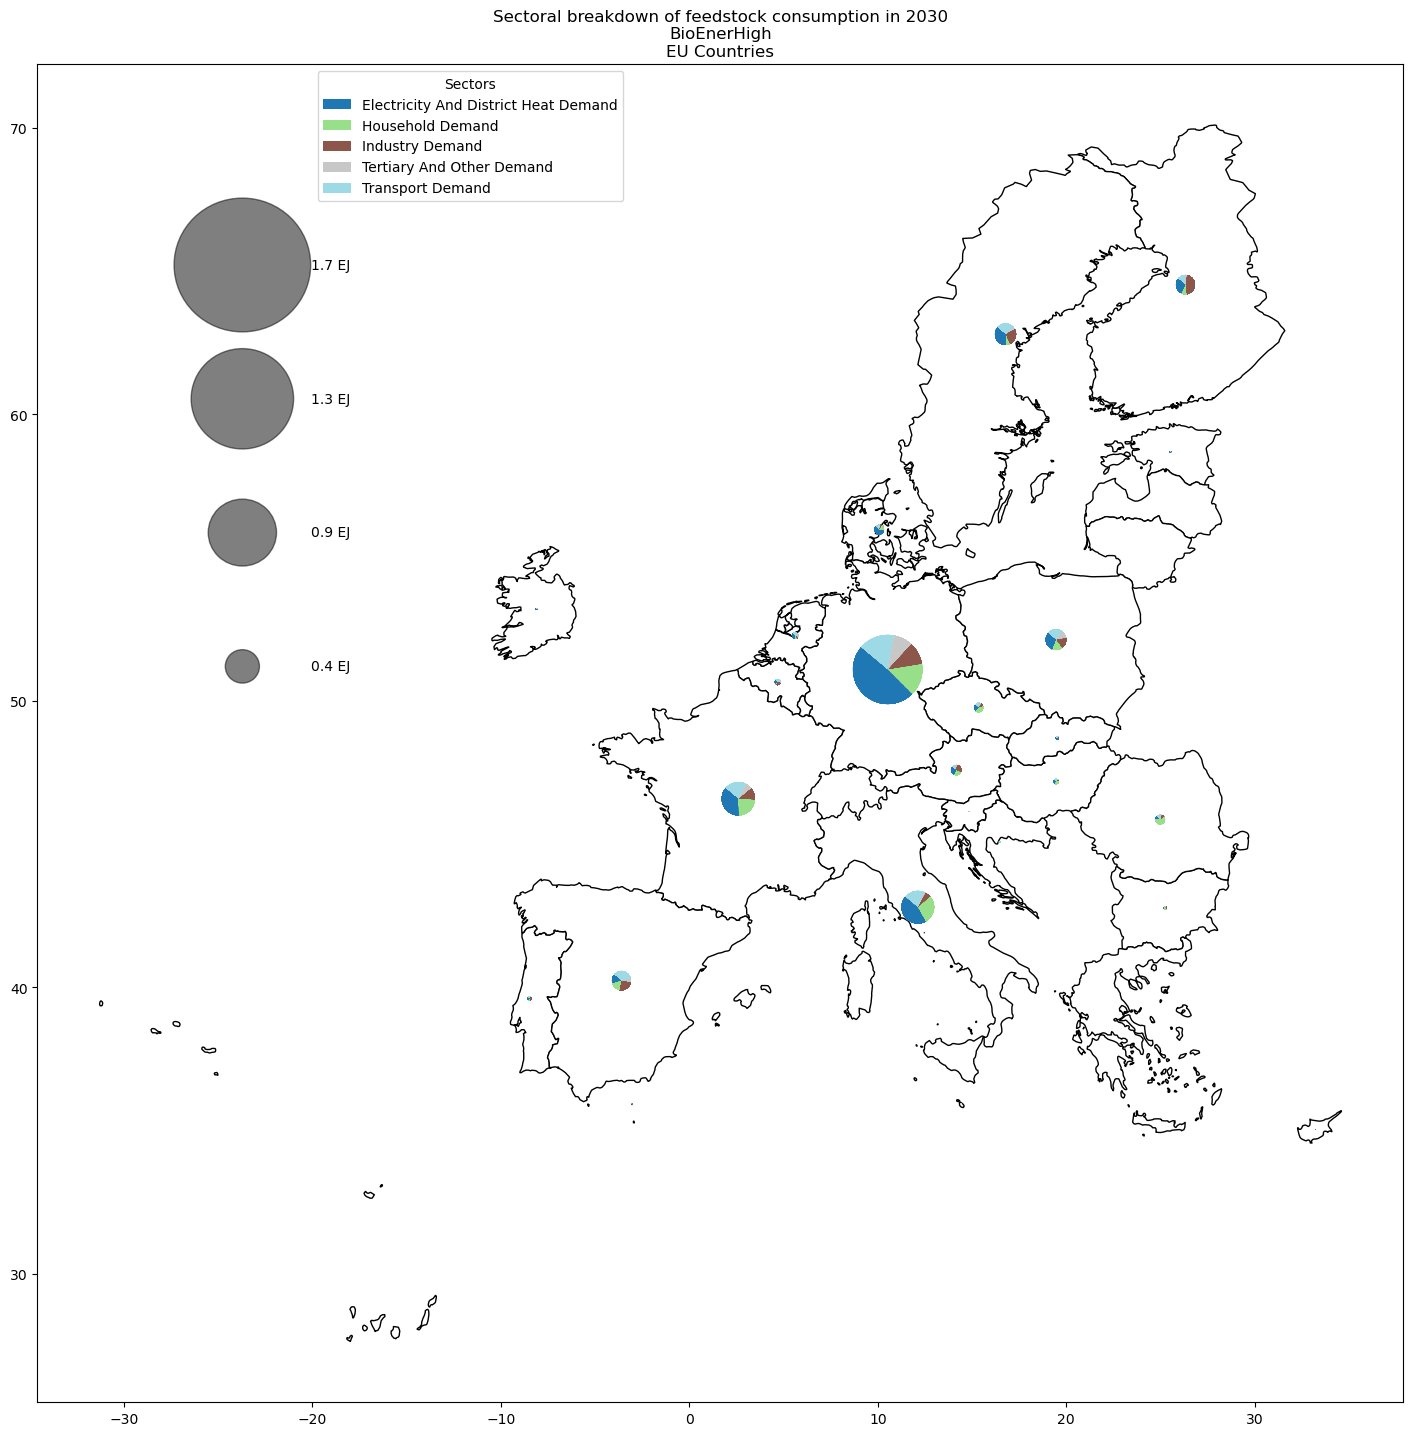

In [101]:
# List of EU countries (as per the sheet names)
eu_countries = [
    "AT", "BE", "BG", "HR", "CY", "CZ", "DK", "EE", "FI", "FR", "DE",
    "GR", "HU", "IE", "IT", "LV", "LT", "LU", "MT", "NL", "PL", "PT",
    "RO", "SK", "SI", "ES", "SE"
]

# Filter to EU countries
eu_borders = country_borders.loc[eu_countries]

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(16, 16))

# Plot EU borders
eu_borders.plot(ax=ax, color='white', edgecolor='black')

# Function to create a pie chart as an image
def pie_image(sizes, colors=None):
    fig, pie_ax = plt.subplots()
    wedges, _ = pie_ax.pie(sizes, labels=None, startangle=140, colors=colors)
    pie_ax.axis('equal')
    fig.patch.set_alpha(0)  # Set the figure background to be transparent
    pie_ax.patch.set_alpha(0)   # Set the axes background to be transparent
    
    fig.canvas.draw()
    
    # Create an image from the figure, ensuring transparency
    image = np.frombuffer(fig.canvas.tostring_argb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    plt.close(fig)
    
    # Reorder ARGB to RGBA
    image = image[:, :, [1, 2, 3, 0]]
    return image, wedges

# Calculate total demand for scaling purposes
total_demands = []
for country_code in eu_countries:
    country_demand = master_df.filter(
        variable="*Demand", 
        region=country_code, 
        scenario="BioEnerHigh", 
        unit="EJ", 
        year=2030
    )
    if not country_demand.empty:
        total_demands.append(country_demand.timeseries().sum().sum())

max_demand = max(total_demands) if total_demands else 1

# Initialize lists for wedges and labels for the pie chart legend
all_wedges = []
all_labels = []

# Loop through each EU country and plot the respective pie chart
for country_code in eu_countries:
    # Filter data for the specific country and year
    country_demand = master_df.filter(
        variable="*Demand", 
        region=country_code, 
        scenario="BioEnerHigh", 
        unit="EJ", 
        year=2030
    )

    # Skip countries with no data
    if country_demand.empty:
        continue

    # Prepare data for pie chart
    sizes = country_demand.timeseries().values.flatten()
    variables = country_demand.timeseries().index.get_level_values('variable').unique()

    # Calculate the centroid of the country
    centroid = eu_borders.loc[country_code].geometry.centroid

    # Create a pie chart image
    pie_img, wedges = pie_image(sizes, colors=plt.cm.tab20(np.linspace(0, 1, len(sizes))))

    # Store wedges and labels for legend
    if not all_wedges:
        all_wedges = wedges
        all_labels = [label.split('|')[-1] for label in variables]

    # Scale factor for pie size based on total demand
    total_demand = sizes.sum()
    scale_factor = 0.15 * (total_demand / max_demand)  # Adjust this scale factor as needed

    # Create an AnnotationBbox with the pie chart image
    imagebox = OffsetImage(pie_img, zoom=scale_factor)
    ab = AnnotationBbox(imagebox, (centroid.x, centroid.y), frameon=False)

    # Add the AnnotationBbox to the plot
    ax.add_artist(ab)

# Create a custom legend for the size scale using nested black circles
legend_labels = [0.25 * max_demand, 0.5 * max_demand, 0.75 * max_demand, max_demand]
legend_positions = [(0.15, 0.55), (0.15, 0.65), (0.15, 0.75), (0.15, 0.85)]

for label, pos in zip(legend_labels, legend_positions):
    scale_factor = 0.05 * (label / max_demand)
    circle = plt.Circle((pos[0], pos[1]), scale_factor, color='black', transform=ax.transAxes, alpha=0.5)
    ax.add_patch(circle)
    ax.text(pos[0] + 0.05, pos[1], f'{label:.1f} EJ', transform=ax.transAxes, fontsize=10, verticalalignment='center')

# Note: Ensure the bbox_to_anchor values are adjusted as needed
pie_legend = ax.legend(all_wedges, all_labels, title="Sectors", loc="best", bbox_to_anchor=(0.2, 1))

# Set the title and layout
ax.set_title("Sectoral breakdown of feedstock consumption in 2030\nBioEnerHigh\nEU Countries")
plt.tight_layout()
plt.show()
